# Exercise #3 - Q-learning

In the first exercise (#1 - Dynamic Programming) we had complete knowledge of the dynamics of the environment. We had a model (through the `p` function) that predicts exactly what will happen in the future. For a lot of environments it is infeasible to get such a model. For these environments we can use algorithms that are model-free. They interact with the environment to discover which actions result in large returns (G) and which actions don't. In this exercise we will implement the Q-learning algorithm using a lookup table.

First let's import the necessary components. We will again use the `numpy` library for working with vectors and matrices and the `gymnasium` library for the learning environment.

In [1]:
import numpy as np
import gymnasium

For this exercise we are going to use the already demonstrated `Taxi-v3` environment.

In [2]:
env = gymnasium.make('Taxi-v3', render_mode='rgb_array')
print(f'Observation: {env.observation_space}, {env.observation_space.dtype}')
print(f'Action:      {env.action_space}, {env.action_space.dtype}')

Observation: Discrete(500), int64
Action:      Discrete(6), int64


The observation is a single integer between 0 and 500 (i.e. the state) and the action is another integer between 0 and 6. This could easily fit in a table, like used in the Q-learning algorithm.

## Q-learning

<img src="figures/q-learning.png" width="50%" align="right"/>The Q-learning algorithm is described in pseudo-code on the right. This algorithm can be broken into a few smaller pieces.

First of all we have to interact with the environment in such a way that we nicely balance exploration and exploitation. If we would only follow a policy that acts greedy, then is quickly settles on a sub-optimal policy. By keeping exploring we will figure out the optimal policy eventually. We will use the $\epsilon$-greedy algorithm to combine a greedy policy with exploration.

In order to determine which action is the best (i.e. act greedy), we have to know the *action value function* $q_\pi(s,a)$. For this implementation we will store an estimate of that in a 2-dimensional array `q` for all the observations and actions possible. This is feasible in this environment because we only have 500 states and 6 actions, resulting in a table of only 3000 elements. The rows in this array are the states and the columns the actions. The value for action `a` in state `s` can be queried with `q[s, a]` or if you need the values of all actions in state `s` you can grab the entire row with `q[s]`.

After every interaction with the environment we will update this table for the action taken with the reward received. This way we will slowly (with factor $\alpha$) update the estimate towards the actual value.

### $\epsilon$-greedy policy



We will use the $\epsilon$-greedy algorithm to combine a greedy policy with exploration. For every time step we will, with probability $\epsilon$, select an action completely at random. With probability $1-\epsilon$ we will select the best (i.e. greedy) action.

Let's first implement a greedy policy. This should simply get the action with the highest value for the current state. You can use the `q` table to get the action values of the given state, and you can use [`np.argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to get the index of the highest value in that row.

In [3]:
def greedy_policy(state):
    global q
    ### START CODE ###
    action = np.argmax(q[state])
    ### END CODE ###
    return action

Now we can implement the $\epsilon$-greedy policy. We will need the function [`np.random.uniform()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) to get a random number between 0 and 1. If that number is less than `epsilon`, then we should sample a completely random action in the environment using `env.action_space.sample()`. Otherwise, you should use the greedy policy you just implemented.

In [4]:
def epsilon_greedy_policy(state, env, greedy_policy, epsilon):
    ### START CODE ###
    if np.random.uniform() < epsilon:
        # Take random action
        action = env.action_space.sample()
    else:
        # Take greedy action
        action = greedy_policy(state)
    ### END CODE ###
    return action

Let's see if it works as intended. If you run the next cell the output should be `3 1`. This means that in the first case it selects at random action `3`, and in the second case it selects the maximum action in state 1 (i.e. acted greedy), which is `1`.

In [5]:
env.action_space.seed(12)
np.random.seed(12)

q = np.array([[1,1,3],[1,2,1]], dtype=np.float32)
a = epsilon_greedy_policy(1, env, greedy_policy, 0.3)
b = epsilon_greedy_policy(1, env, greedy_policy, 0.3)
print(a, b)

3 1


### Update Q values

Now we will implement the update of the action value table `q`. After an interaction with the environment we get a new state and a reward. With this information we can create a new target value for the $q(s,a)$ estimate.

The next steps are based on a few assumptions. First of all, we assume that after this interaction we will follow only the greedy policy, so we can predict what will happen. Furthermore, we will assume that action values we have estimated so far are good estimates which we can use to make predictions, i.e. we assume they estimate the optimal function $q_*(s,a)$.

The Bellman optimality equation for the the action value function is described as follows.

$$
q_*(s,a) \doteq \mathop{\mathbb{E}} \left[ R_{t+1} + \gamma \underset{a'}\max {q_*(S_{t+1}, a')} \big| S_t=s,A_t=a \right]
$$

The reward $r$ and next state $s'$ are a sample of the environment, so if we slowly update our estimate for $q_\pi(s,a)$ using this sample, then we know we will slowly converge towards the optimal action value function. In other words, the target for our value function is

$$r + \gamma \underset{a'}\max {q_\pi(s',a')}$$

We want to slowly move towards that target, so we can implement this as follows:

$$q(s,a) = q(s,a) + \alpha [r + \gamma \underset{a'}\max {q_\pi(s',a')} - q(s,a)]$$

Time to implement this in `update_action_values` below. The current table is given as parameter `q` and we will replace the value for the current state-action pair with a new estimate. For this we will need the numpy function [`np.amax`](https://numpy.org/doc/stable/reference/generated/numpy.amax.html) to find the maximum value of an array. Remember that you can use `q[s]` to get the values of all actions in a state.

In [6]:
def update_action_values(state, action, reward, next_state, q, alpha, gamma):
    ### START CODE ###
    q[state, action] += alpha * (reward + gamma * np.amax(q[next_state]) - q[state, action])
    ### END CODE

Let's test the implemention with the following unit test. We have a fictive table `q` for 2 states and 3 actions. In state 0 action 2 was taken which resulted in reward -1 and next state 1. So let's update the action values.

In [7]:
q = np.array([[1,1,3],[1,2,1]], dtype=np.float32)
print(q[0])
update_action_values(0, 2, -1, 1, q, 0.1, 0.9)
print(q[0])

[1. 1. 3.]
[1.   1.   2.78]


The output should be equal to:

    [1. 1. 3.]
    [1.   1.   2.78]

In other words, the value for action 2 in state 0 should be updated as a result of reward -1.

## Learn

That's all the components we need for this algorithm. Time to put it all together.

In the previous exercise we already implemented the main loop for running an environment with the additional bookkeeping. Let's import that.

In [8]:
from utils import run_environment

This function requires a two important parts. It needs a policy function to select the right action. We should be using the `epsilon_greedy_policy` that we have created before.

We also want to update the action values table `q` after every step, so an `on_step` function needs to be provided that properly calls the already created function`update_action_values`.

Fill in these functions and execute the cell, this will start a training run for 5000 episodes, which should be plenty enough to fill the table.

In [9]:
alpha, gamma, epsilon = 0.1, 0.8, 0.3

q = np.zeros([env.observation_space.n, env.action_space.n])

def policy(observation):
    ### START CODE ###
    # Get an action using the epsilon-greedy policy
    action = epsilon_greedy_policy(observation, env, greedy_policy, epsilon)
    ### END CODE ###
    return action

def on_step(observation, action, next_observation, reward, done, length, score):
    ### START CODE ###
    # Update action values
    update_action_values(observation, action, reward, next_observation, q, alpha, gamma)
    ### END CODE ###

run_environment(env, 5000, policy, on_step)

100%|██████████| 5000/5000 [00:07<00:00, 676.04it/s, avg_length=19.7, avg_score=-14.6] 


Now we have learned a policy that should behave close to optimal. Time to see it in action.

## Evaluate

To see how our policy performs we will run a complete episode with the greedy policy. We want to exploit completely, no more exploring. We already implemented a `greedy_policy` function as part of the $\epsilon$-greedy implementation.

We will be using the `evaluate` function that we have created in the previous exercise. We just need to call it with the proper policy function and run it. It should a single run and return the length and sum of all reward (the return) of the episode.

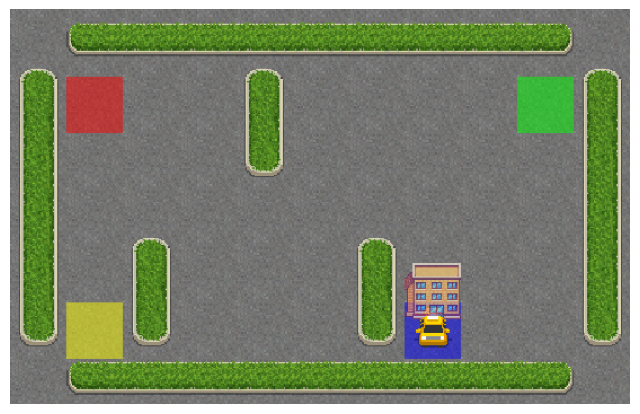

Episode length: 12, return: 9


(12, 9)

In [10]:
from utils import evaluate

### START CODE ###
# Invoke evaluate with the greedy policy
evaluate(env, greedy_policy)
### END CODE ###

## Conclusion

That's it. You have now learned a policy that performs optimally without using a model to predict what happens in the environment. By simply interacting with the environment we learned which actions are good and which aren't.

The amount of computation needed is not that much, but that's mainly because we can use a table with limited number of entries. For environments with lots of states and/or actions this algorithm is no longer feasible. For that we need to use function approximations, which we will do in the next exercise.